# Topic Modelling
In this notebook we create a topic model for the text and also per article. The topic models are created as word clouds for easy visualization but tables are also possible.

First let us import the necessary libraries

Then load the text and create a pandas dataframe.

### installations
Kannst du überspringen, wenn du das python venv mit requirements erstellt hast

In [2]:
!pip install pandas

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)


In [4]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [6]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)


In [20]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 29.4 MB/s eta 0:00:0000:0100:01


In [31]:
!pip install wordcloud

### Imports

In [1]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

from gensim.utils import simple_preprocess
import spacy
from spacy.tokenizer import Tokenizer
from tqdm import tqdm as tq
from random import shuffle
from gensim import corpora
from gensim.models.ldamodel import LdaModel

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel

from sklearn import metrics

/home/genta/Documents/notebooks_cs/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("/home/genta/Documents/notebooks_cs/grs-002_1984_76__218_d.txt","r") as fin:
    input_text = fin.readlines()
df = pd.DataFrame(input_text, columns=["text"])

## Entire text
This is topic modelling on the level of the entire text.

### WordCloud
In this type of topic modelling, we don't do much by hand but can display the topics in a nice "word cloud".

But first, once more, we decide on the number of topics:

In [3]:
N_TOPICS = 1

In [44]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 29.1 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [4]:
#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('de_core_news_sm')

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) 
            if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(df['text']):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))

# randomize document order
shuffle(doc_clean)

# creating the term dictionary
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
# dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
lda = LdaModel(doc_term_matrix, num_topics=N_TOPICS,
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


[(0,
  '0.014*"ausweis" + 0.012*"datum" + 0.010*"arbeitnehmer" + 0.010*"sulzer" + 0.009*"winterthur" + 0.009*"wirth" + 0.009*"isler" + 0.008*"betriebskommission" + 0.007*"art" + 0.007*"elektronisch"')]

With the computations done, let us look at the nice word clouds :)

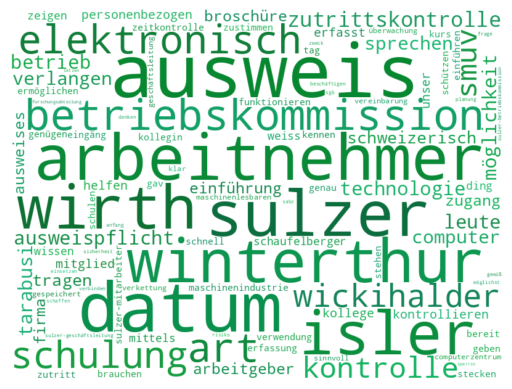

In [5]:
###
# LDA Word Clouds
###
#https://github.com/elliottash/nlp_lss_2023/blob/master/notebooks/03_topic_models.ipynb

# make directory if not exists to save the word cloud images in it.
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=N_TOPICS,
                                 num_words=100,
                                 formatted=False):

    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None,
                  position=None, orientation=None,
                  font_path=None, random_state=None):
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)


    wordcloud = WordCloud(background_color="white",
                          ranks_only=True,
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Embedding space
Here we embed the articles to find out if they're on similar topics.

Here you create the articles dictionary

In [16]:
with open("grs-002_1984_76__216_d.txt","r") as fin:
    input_text_1 = fin.readlines()
    if len(input_text_1) == 1:
        input_text_1 = input_text_1.split(".")

with open("grs-002_1984_76__218_d.txt","r") as fin:
    input_text_2 = fin.readlines()
    if len(input_text_2) == 1:
        input_text_2 = input_text_2.split(".")

with open("grs-002_1984_76__219_d.txt","r") as fin:
    input_text_4 = fin.readlines()
    if len(input_text_4) == 1:
        input_text_4 = input_text_4.split(".")

with open("grs-002_1984_76__277_d.txt","r") as fin:
    input_text_3 = fin.readlines()
    if len(input_text_3) == 1:
        input_text_3 = input_text_3.split(".")

#create dictionary for each article
article_dict = {"article1": {"text": input_text_1}, "article_2":{"text":input_text_2}, "article3": {"text":input_text_3}, "article4":{"text":input_text_4}}

AttributeError: 'list' object has no attribute 'split'


Here we load the necessary libraries, tokenizer and model.

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-cased',
                                  output_hidden_states = True) # Whether the model returns all hidden-states
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

This part checks if we have a GPU, and if we do it runs the computation on GPU. That makes the embedding much faster.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

We go through each article and embed what it said. To be exact, we embed each word and then average it out over a 
sentence. This takes around 3 minutes on GPU, and around 20 minutes on CPU.

In [13]:
for article_i in article_dict.keys():
    bert_emb = []
    for i, sentence in enumerate(article_dict[article_i]["text"]):
        #tokenize text
        bert_tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            outputs = model(bert_tokens["input_ids"], bert_tokens["attention_mask"])
            state = outputs["last_hidden_state"]
            #sentence (mean) embeddings
            emb = (state*bert_tokens["attention_mask"][:,:,None]).sum(dim=1) / bert_tokens["attention_mask"][:,:,None].sum(dim=1)
            bert_emb.append(emb)
    article_dict[article_i]["bert_embedding"] = bert_emb

AttributeError: 'list' object has no attribute 'split'

We average everything each article says and create a matrix of the embeddings.

In [10]:
V = []
origin = np.array([[0]*768,[0]*768])
for article_i in article_dict.keys():
    mean = (sum(article_dict[article_i]["bert_embedding"]) / len(article_dict[article_i]["bert_embedding"]))
    V.append(mean)
V = torch.stack(V).cpu().detach().numpy()

We create the distance matrix of each article to each article.

In [11]:
distance_matrix = metrics.pairwise_distances(V[:,0,:])

#the distance of the article_i to itself is set to infinite
for i in range(len(distance_matrix)):
    distance_matrix[i][i] = np.inf

And finally we save the result.

In [12]:
np.savetxt("distance_matrix.csv", distance_matrix, delimiter=",", header = ",".join(article_dict.keys()))